In [1]:
import pathlib
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from collections import deque

In [2]:
# BODY_25 Output Format
keypointsMapping = {
    0: 'Nose',
    1: 'Neck',
    2: 'RShoulder',
    3: 'RElbow',
    4: 'RWrist',
    5: 'LShoulder',
    6: 'LElbow',
    7: 'LWrist',
    8: 'MidHip',
    9: 'RHip',
    10: 'RKnee',
    11: 'RAnkle',
    12: 'LHip',
    13: 'LKnee',
    14: 'LAnkle',
    15: 'REye',
    16: 'LEye',
    17: 'REar',
    18: 'LEar',
    19: "LBigToe",
    20: "LSmallToe",
    21: "LHeel",
    22: "RBigToe",
    23: "RSmallToe",
    24: "RHeel",
    25: "Background"
}

# データフレームの読み込み

In [3]:
# path
root_dir = pathlib.Path("../../data/fashion550k").resolve()
original_csv_path = root_dir / "dataframe.csv"
s0_csv_path = pathlib.Path("./selection0/select_df.csv")
save_dir = pathlib.Path("selection4")
if not save_dir.exists():
    save_dir.mkdir()
# データ選択０で指定されたデータフレーム
df = pd.read_csv(s0_csv_path)
print("データ数:", len(df))
df.head()

データ数: 391798


img_path  \
0  /home/yohei/Documents/tlab/data/fashion550k/ph...   
1  /home/yohei/Documents/tlab/data/fashion550k/ph...   
2  /home/yohei/Documents/tlab/data/fashion550k/ph...   
3  /home/yohei/Documents/tlab/data/fashion550k/ph...   
4  /home/yohei/Documents/tlab/data/fashion550k/ph...   

                                       keypoint_path  \
0  /home/yohei/Documents/tlab/data/fashion550k/an...   
1  /home/yohei/Documents/tlab/data/fashion550k/an...   
2  /home/yohei/Documents/tlab/data/fashion550k/an...   
3  /home/yohei/Documents/tlab/data/fashion550k/an...   
4  /home/yohei/Documents/tlab/data/fashion550k/an...   

                                     visualized_path  
0  /home/yohei/Documents/tlab/data/fashion550k/an...  
1  /home/yohei/Documents/tlab/data/fashion550k/an...  
2  /home/yohei/Documents/tlab/data/fashion550k/an...  
3  /home/yohei/Documents/tlab/data/fashion550k/an...  
4  /home/yohei/Documents/tlab/data/fashion550k/an...

# データ選択2

- 基準：目・耳・鼻 [0, 15, 16, 17, 18] のいずれか1つ ＋ 左半身 [1, 2, 3, 4, 8, 9, 10, 11] or 右半身 [1, 5, 6, 7, 8, 12, 13, 14] の推定値が閾値より大きい値かどうか

In [4]:
# 注目する位置
attention1 = [0, 15, 16, 17, 18]
attention2 = [1, 2, 3, 4, 8, 9, 10, 11]
attention3 = [1, 5, 6, 7, 8, 12, 13, 14]

for a in (attention1):
    print(keypointsMapping[a], end=", ")
print()
for a in (attention2):
    print(keypointsMapping[a], end=", ")
print()
for a in (attention3):
    print(keypointsMapping[a], end=", ")
print()

Nose, REye, LEye, REar, LEar, 
Neck, RShoulder, RElbow, RWrist, MidHip, RHip, RKnee, RAnkle, 
Neck, LShoulder, LElbow, LWrist, MidHip, LHip, LKnee, LAnkle, 


## 閾値 0の場合

In [23]:
# 全画像でやってみる
index = deque(maxlen=len(df) + 100)
threshold = 0  # 閾値
for i, (_, keypoints_path, _) in tqdm(df.iterrows()):
    keypoints = np.load(keypoints_path)
    
    judge1 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention2, 2] > threshold)
    judge2 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention3, 2] > threshold)
    judge = judge1 or judge2
    if judge:
        index.append(True)
    else:
        index.append(False)

len(index) == len(df)

True

In [24]:
# 基準にあったもの
s_df = df[pd.Series(index)].reset_index(drop=True)

# 基準にあってないもの
def not4index(i):
    return not i
hoge = pd.Series(map(not4index, index))
d_df = df[hoge].reset_index(drop=True)

print("基準を満たしたデータ数 ： {} | 基準を満たさなかったデータ数 : {}".format(len(s_df), len(d_df)))

基準を満たしたデータ数 ： 383473 | 基準を満たさなかったデータ数 : 8325


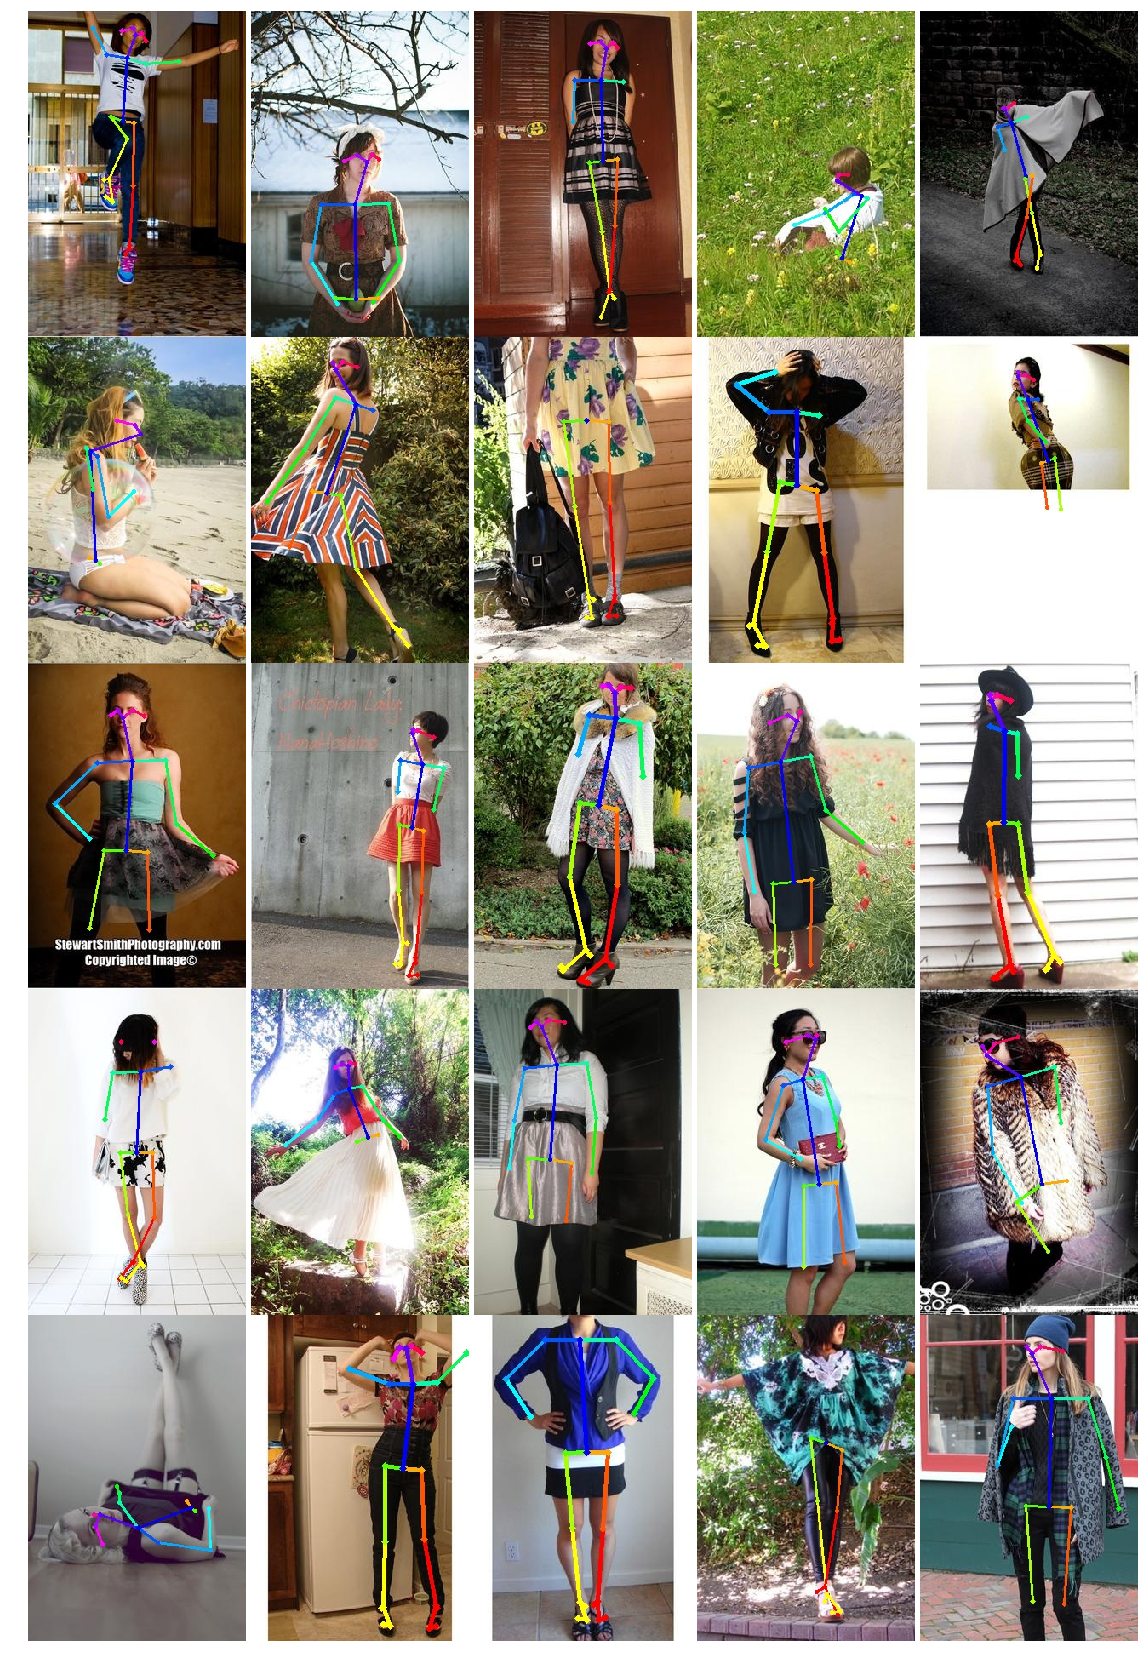

In [25]:
# 基準を満たさなかったデータを可視化
fig, axes = plt.subplots(5, 5, figsize=(20, 30))
for (i, (_, _, visualized_path)), ax in zip(d_df.iterrows(), axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(visualized_path)), cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_axis_off()
plt.subplots_adjust(hspace=0, wspace=0)
fig.savefig(save_dir / "example.png", bbox_inches='tight', pad_inches=0)

In [8]:
# 保存
s_df.to_csv(save_dir / "selection00_df.csv", index=False)
d_df.to_csv(save_dir / "deprecation00_df.csv", index=False)

## 閾値 0.1の場合

In [9]:
# 全画像でやってみる
index = deque(maxlen=len(df) + 100)
threshold = 0.1  # 閾値
for i, (_, keypoints_path, _) in tqdm(df.iterrows()):
    keypoints = np.load(keypoints_path)
    judge1 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention2, 2] > threshold)
    judge2 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention3, 2] > threshold)
    judge = judge1 or judge2
    if judge:
        index.append(True)
    else:
        index.append(False)

len(index) == len(df)

True

In [10]:
# 基準にあったもの
s_df = df[pd.Series(index)].reset_index(drop=True)

# 基準にあってないもの
def not4index(i):
    return not i
hoge = pd.Series(map(not4index, index))
d_df = df[hoge].reset_index(drop=True)


s_df.to_csv(save_dir / "selection01_df.csv", index=False)
d_df.to_csv(save_dir / "deprecation01_df.csv", index=False)

print("基準を満たしたデータ数 ： {} | 基準を満たさなかったデータ数 : {}".format(len(s_df), len(d_df)))

基準を満たしたデータ数 ： 378616 | 基準を満たさなかったデータ数 : 13182


## 閾値 0.2の場合

In [11]:
# 全画像でやってみる
index = deque(maxlen=len(df) + 100)
threshold = 0.2  # 閾値
for i, (_, keypoints_path, _) in tqdm(df.iterrows()):
    keypoints = np.load(keypoints_path)
    judge1 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention2, 2] > threshold)
    judge2 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention3, 2] > threshold)
    judge = judge1 or judge2
    if judge:
        index.append(True)
    else:
        index.append(False)

len(index) == len(df)

True

In [12]:
# 基準にあったもの
s_df = df[pd.Series(index)].reset_index(drop=True)

# 基準にあってないもの
def not4index(i):
    return not i
hoge = pd.Series(map(not4index, index))
d_df = df[hoge].reset_index(drop=True)

s_df.to_csv(save_dir / "selection02_df.csv", index=False)
d_df.to_csv(save_dir / "deprecation02_df.csv", index=False)

print("基準を満たしたデータ数 ： {} | 基準を満たさなかったデータ数 : {}".format(len(s_df), len(d_df)))

基準を満たしたデータ数 ： 368592 | 基準を満たさなかったデータ数 : 23206


## 閾値 0.3の場合

In [13]:
# 全画像でやってみる
index = deque(maxlen=len(df) + 100)
threshold = 0.3  # 閾値
for i, (_, keypoints_path, _) in tqdm(df.iterrows()):
    keypoints = np.load(keypoints_path)
    judge1 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention2, 2] > threshold)
    judge2 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention3, 2] > threshold)
    judge = judge1 or judge2
    if judge:
        index.append(True)
    else:
        index.append(False)

len(index) == len(df)

True

In [14]:
# 基準にあったもの
s_df = df[pd.Series(index)].reset_index(drop=True)

# 基準にあってないもの
def not4index(i):
    return not i
hoge = pd.Series(map(not4index, index))
d_df = df[hoge].reset_index(drop=True)

s_df.to_csv(save_dir / "selection03_df.csv", index=False)
d_df.to_csv(save_dir / "deprecation03_df.csv", index=False)

print("基準を満たしたデータ数 ： {} | 基準を満たさなかったデータ数 : {}".format(len(s_df), len(d_df)))

基準を満たしたデータ数 ： 356121 | 基準を満たさなかったデータ数 : 35677


## 閾値 0.4の場合

In [15]:
# 全画像でやってみる
index = deque(maxlen=len(df) + 100)
threshold = 0.4  # 閾値
for i, (_, keypoints_path, _) in tqdm(df.iterrows()):
    keypoints = np.load(keypoints_path)
    judge1 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention2, 2] > threshold)
    judge2 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention3, 2] > threshold)
    judge = judge1 or judge2
    if judge:
        index.append(True)
    else:
        index.append(False)

len(index) == len(df)

True

In [16]:
# 基準にあったもの
s_df = df[pd.Series(index)].reset_index(drop=True)

# 基準にあってないもの
def not4index(i):
    return not i
hoge = pd.Series(map(not4index, index))
d_df = df[hoge].reset_index(drop=True)

s_df.to_csv(save_dir / "selection04_df.csv", index=False)
d_df.to_csv(save_dir / "deprecation04_df.csv", index=False)

print("基準を満たしたデータ数 ： {} | 基準を満たさなかったデータ数 : {}".format(len(s_df), len(d_df)))

基準を満たしたデータ数 ： 337790 | 基準を満たさなかったデータ数 : 54008


## 閾値 0.5の場合

In [17]:
# 全画像でやってみる
index = deque(maxlen=len(df) + 100)
threshold = 0.5  # 閾値
for i, (_, keypoints_path, _) in tqdm(df.iterrows()):
    keypoints = np.load(keypoints_path)
    judge1 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention2, 2] > threshold)
    judge2 = np.any(keypoints[:, attention1, 2] > threshold) and np.all(
        keypoints[:, attention3, 2] > threshold)
    judge = judge1 or judge2
    if judge:
        index.append(True)
    else:
        index.append(False)

len(index) == len(df)

True

In [18]:
# 基準にあったもの
s_df = df[pd.Series(index)].reset_index(drop=True)

# 基準にあってないもの
def not4index(i):
    return not i
hoge = pd.Series(map(not4index, index))
d_df = df[hoge].reset_index(drop=True)

s_df.to_csv(save_dir / "selection05_df.csv", index=False)
d_df.to_csv(save_dir / "deprecation05_df.csv", index=False)

print("基準を満たしたデータ数 ： {} | 基準を満たさなかったデータ数 : {}".format(len(s_df), len(d_df)))

基準を満たしたデータ数 ： 298593 | 基準を満たさなかったデータ数 : 93205


# 閾値ごとにデータ数を棒グラフにする．

In [19]:
data_length = []
for i in range(6):
    path = save_dir / "selection0{}_df.csv".format(i)
    assert path.exists(), "{}".format(path)
    tmp = pd.read_csv(path)
    data_length.append(len(tmp))

In [20]:
data_length

[383473, 378616, 368592, 356121, 337790, 298593]

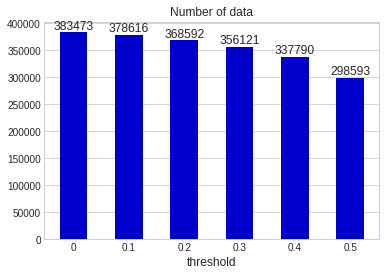

In [26]:
plt.style.use("seaborn-whitegrid")

x = list(range(6))
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.title("Number of data")
plt.bar(x, data_length, color="mediumblue", width=0.5, align="center")
plt.grid(axis="x")

# 棒グラフ内に数値を書く
for x_, y_ in zip(x, data_length):
    plt.text(x_, y_, str(y_), ha='center', va='bottom', fontdict={"fontsize":12})
plt.xlabel("threshold", fontdict={"fontsize":12})
_ = plt.xticks(x, thresholds)
plt.savefig(save_dir / "selection4_bar.png")

# 閾値ごとに平均画像を取ってみる

In [22]:
mean = []
for i in tqdm(range(6)):
    path = save_dir / "selection0{}_df.csv".format(i)
    tmp = pd.read_csv(path)
    sum_ = np.zeros((384, 256, 3))
    for i, (img_path, _, _) in tqdm(tmp.iterrows()):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        sum_ += img
    mean.append(sum_ / len(tmp) / 255)

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(40, 10))
for img, ax in zip(mean, axes.flatten()):
    ax.imshow(img)
    ax.set_axis_off()
plt.subplots_adjust(hspace=0, wspace=0)
fig.savefig(save_dir / "mean.png", bbox_inches='tight', pad_inches=0)